gg-napari-env

In [1]:
import napari
from napari_czifile2 import napari_get_reader
from cellpose import models, plot, utils, core, models, train
from cellpose.io import logger_setup
import cellpose.io as cio 
import torch 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import find_contours
import pandas as pd
import skimage.exposure as exposure
from skimage.morphology import remove_small_objects
import numpy as np
from skimage.measure import label, regionprops
import seaborn as sns
import os 
import sys 
from skimage.transform import resize
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold
from skimage.exposure import equalize_adapthist
from skimage.measure import label, regionprops
from scipy.ndimage import binary_erosion, gaussian_filter, binary_dilation, binary_fill_holes
from skimage import exposure
import sys 
from plotting import * 
white_plotting()
import warnings
import matplotlib.font_manager as fm
fm.fontManager.__init__()
warnings.filterwarnings("ignore")
use_GPU = core.use_gpu()
torch.cuda.empty_cache()
print('>>> GPU activated? %d'%use_GPU)
logger_setup()

Initializing plotting package
>>> GPU activated? 1
2025-03-27 15:46:46,820 [INFO] WRITING LOG OUTPUT TO /home/tracking/.cellpose/run.log
2025-03-27 15:46:46,821 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.12.8 
torch version:  	2.5.1+cu124


(<Logger cellpose.io (INFO)>, PosixPath('/home/tracking/.cellpose/run.log'))

## 9E198-B3-488 & 9E197-B1-546 & 9E196-B2-647 & DAPI

Try to plot 9E196, 197 and 198 as a heatmaps, similar to snRNAseq data

In [3]:
input = '20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi'
results_dir = f'../results/{input}'
results_files = os.listdir(results_dir)
results_files = [f for f in results_files if f.endswith('.csv')]

# Load all results 
results = pd.DataFrame() 
for f in results_files:
    results_path = os.path.join(results_dir, f)
    results = pd.concat([results, pd.read_csv(results_path)], axis=0) 

results

,z_id,image,z,count,area,centroid_x,centroid_y,AF546-T1,AF488-T2,AF647-T3
0,1,20250325 5 t35 sample 4 great.czi,8,0,7.755255,635.649510,1543.416667,1.659314,11.813725,2.161765
1,2,20250325 5 t35 sample 4 great.czi,8,1,6.643288,683.509299,1587.805436,1.866953,10.776824,2.178827
2,1,20250325 5 t35 sample 4 great.czi,9,2,6.738328,638.978843,1544.925247,1.606488,9.894217,1.912553
3,2,20250325 5 t35 sample 4 great.czi,9,3,6.823864,593.323120,1640.267409,1.540390,9.032033,2.229805
4,1,20250325 5 t35 sample 4 great.czi,10,4,6.985432,784.170068,1268.906122,1.597279,9.923810,1.927891
...,...,...,...,...,...,...,...,...,...,...
30845,1,20250325 5 t35 sample 1 great.czi,84,30845,6.690808,668.596591,898.901989,1.488636,5.572443,1.882102
30846,2,20250325 5 t35 sample 1 great.czi,84,30846,8.648630,713.894505,928.036264,1.472527,6.165934,2.094505
30847,3,20250325 5 t35 sample 1 great.czi,84,30847,5.227194,668.918182,927.927273,1.709091,6.161818,1.676364
30848,4,20250325 5 t35 sample 1 great.czi,84,30848,5.141658,691.702403,951.445471,1.388170,5.959335,1.780037


In [7]:
channel_names = ["9E196", "9E197", "9E198"]
channels = ["AF647-T3", "AF546-T1", "AF488-T2"]

In [39]:
expression_data = results[["AF647-T3", "AF546-T1", "AF488-T2"]].values
# Normalize each columnn to 0-1 
expression_data = (expression_data - expression_data.min(axis=0)) / (expression_data.max(axis=0) - expression_data.min(axis=0))
expression_data = pd.DataFrame(expression_data, columns=channel_names)

# Find top OR 
expression_data['top_or'] = expression_data.idxmax(axis=1) 
expression_data['top_or'] = pd.Categorical(expression_data['top_or'], categories=channel_names, ordered=True)
expression_data['top_or_expression'] = expression_data.iloc[:, :-1].max(axis=1)
expression_data = expression_data.sort_values(['top_or'], ascending=True)
expression_data

,9E196,9E197,9E198,top_or,top_or_expression
59620,0.086789,0.063700,0.058047,9E196,0.086789
54383,0.115336,0.017399,0.072215,9E196,0.115336
10209,0.073139,0.003832,0.068088,9E196,0.073139
90554,0.805537,0.004512,0.625257,9E196,0.805537
17743,0.332297,0.006949,0.173244,9E196,0.332297
...,...,...,...,...,...
38416,0.006059,0.002547,0.062131,9E198,0.062131
38415,0.008206,0.005321,0.054735,9E198,0.054735
38414,0.017376,0.009305,0.091664,9E198,0.091664
38425,0.004487,0.003037,0.051918,9E198,0.051918


In [40]:
expression_data_high = expression_data[expression_data['top_or_expression'] > 0.5]
expression_data_high.shape

(305, 5)

<Axes: >

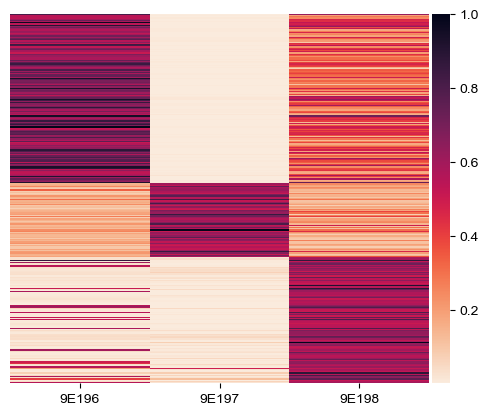

In [41]:
sns.heatmap(expression_data_high.iloc[:, :-2], 
            cmap=sns.color_palette("rocket_r", as_cmap=True), 
            xticklabels=True, 
            yticklabels=False, 
            cbar_kws={'pad': 0.005}
            )